In [23]:
%matplotlib inline
import skyflux as sf

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [49]:
# Set up a healpy interpolator

nside = 64

theta, phi = hp.pix2ang(nside,np.arange(12 * nside * nside))

#! I think we will have to revisit these values to expand the healpy
    # interpolator, once we have tested it out at least once.
list_az = phi
list_alt = np.pi / 2 - theta
#J = sf.stokes.spline_beam_func(151e6, alt, az)

# Not 100% sure about this lack of LST arg
J = sf.stokes.create_J(az=list_az, alt=list_alt, nu=151e6, radians=True)
J_abs = np.abs(J)

In [50]:
J.shape
A_full = np.array([
  sf.stokes.create_A(J=Ji) for Ji in J  
])


In [51]:
A_full.shape

(49152, 4, 4)

In [52]:
lst_now_deg = np.degrees(sf.rot.get_lst(radians=False))
az, alt = sf.rot.eq_to_topo(lst_now_deg, sf.rot.hera_lat, 
                            sf.rot.hera_lat, lst_now_deg, radians=False)

In [60]:
def val_interp(A_section, az, alt):
    """
    Abbreviation and conversion function. We get the interpolation value
    assuming @az and @alt are in degrees.
    """
    colatitude = np.radians(90 - alt)
    longitude = np.radians(az)
    return hp.get_interp_val(A_section, colatitude, longitude)

A_shell = np.zeros((4, 4), dtype=np.complex128)

def A_interp(A_full):
    def interpolator(az, alt):
        colatitude = np.pi / 2 - alt
        longitude = az
        A = np.array(np.ones((4, 4), dtype=np.complex128))
        for i in range(0, 4):
            for j in range(0, 4):
                A[i, j] = hp.get_interp_val(A_full[:, i, j], colatitude, longitude)
        return A
    return interpolator

def minimal_A_interp(A_full):
    def interpolator(az, alt):
        colatitude = np.pi / 2 - alt
        longitude = az
        A = np.copy(A_shell)
        for i in range(0, 4):
            A[i, 0] = hp.get_interp_val(A_full[:, i, 0], colatitude, longitude)
        return A
    return interpolator

In [61]:
# Display available antennae
print(sf.demo.active_ants)

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]


In [62]:
min_residual = 100
target = sf.rot.hera_lat
best_i = -1
for i in range(len(sf.catalog.obj_catalog)):
    obj = sf.catalog.obj_catalog[i]
    residual = (obj.dec_angle - target) ** 2
    if residual < min_residual:
        min_residual = residual
        best_i = i
print(best_i)
print(sf.catalog.obj_catalog[best_i])
best_source = sf.catalog.obj_catalog[best_i]
print("Flux at 151MHz:", best_source.flux_by_frq[151])
# also, would we not expect the first term to dominate? And yet it is not even the largest
    # of numbers all with magnitudes less than one

2581
Name: GLEAM J150108-311646
Right ascension: 225.285125
Declination: -30.72038888888889
151 MHz flux: 2.077937

Flux at 151MHz: 2.077937


In [63]:
ra = np.radians(best_source.ra_angle)
dec = np.radians(best_source.dec_angle)
#dec = np.radians(sf.rot.hera_lat)

r = sf.rot.radec2lm(ra, dec, ra0=0)

print(r)

print(sf.ant.baseline(88, 121)[0:2])

(0.6108963584497026, 0.7481512996167696)
[-43.92014994  25.13624112]


In [64]:
interpolator = A_interp(A_full)
A_imitation = interpolator(0, 0)
A_actual = sf.stokes.create_A(az=0, alt=0, radians=True)
print(A_imitation)
print(A_imitation.shape)
print(A_actual)
print(A_actual.shape)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
(4, 4)
[[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]]]
(4, 1, 4)


In [65]:
list_lst, list_vis = sf.vis.new_sources_over_time(
    88, 121, best_source, np.pi, 2 * np.pi, np.pi / 288, nu=151e6,
    interpolator = minimal_A_interp(A_full)
)
#vist

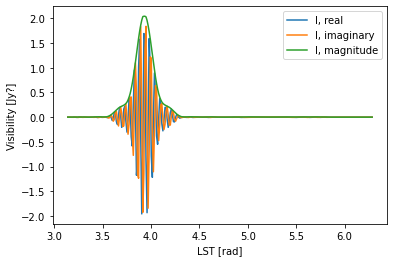

In [66]:
I = np.array([v[0] for v in list_vis])

plt.plot(list_lst, np.real(I), label="I, real")
plt.plot(list_lst, np.imag(I), label="I, imaginary")
plt.plot(list_lst, np.abs(I), label="I, magnitude")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

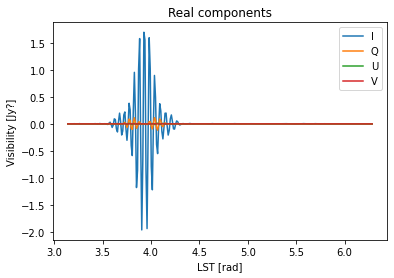

In [67]:
Q = np.array([v[1] for v in list_vis])
U = np.array([v[2] for v in list_vis])
V = np.array([v[3] for v in list_vis])

plt.plot(list_lst, np.real(I), label="I")
plt.plot(list_lst, np.real(Q), label="Q")
plt.plot(list_lst, np.real(U), label="U")
plt.plot(list_lst, np.real(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Real components")

plt.legend()
plt.show()

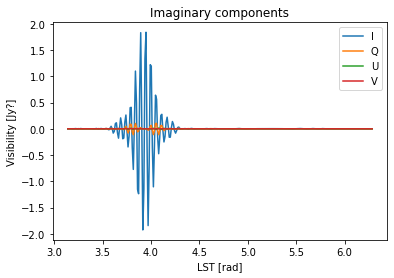

In [68]:
plt.plot(list_lst, np.imag(I), label="I")
plt.plot(list_lst, np.imag(Q), label="Q")
plt.plot(list_lst, np.imag(U), label="U")
plt.plot(list_lst, np.imag(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Imaginary components")

plt.legend()
plt.show()

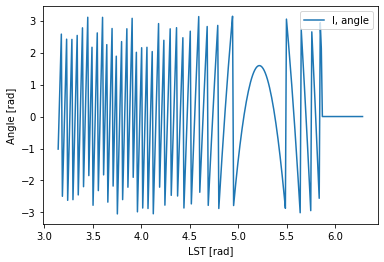

In [46]:
# it is like a phase wrapping effect, that is why there is a sort of symmetry about the soft lump

plt.plot(list_lst, np.angle(I), label="I, angle")

plt.xlabel("LST [rad]")
plt.ylabel("Angle [rad]")

plt.legend()
plt.show()

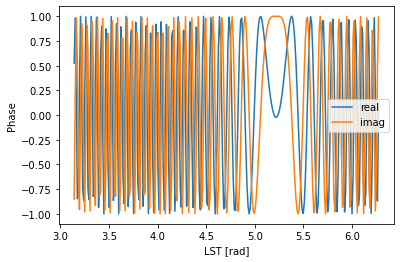

In [47]:
lst_list = [np.pi / 288 * i for i in range(288, 576)]

#print(lst_list)

phases = np.array([sf.ant.phase_factor(88, 121, sf.rot.radec2lm(ra, dec, ra0=lst)) for lst in 
    lst_list
])
plt.plot(lst_list, np.real(phases), label="real")
plt.plot(lst_list, np.imag(phases), label="imag")

plt.xlabel("LST [rad]")
plt.ylabel("Phase")

plt.legend()
plt.show()

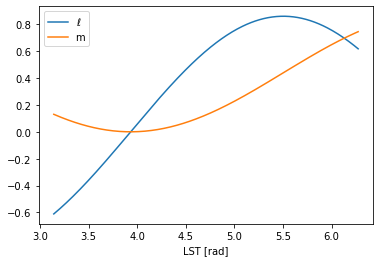

In [48]:
# The source does not pass through zenith
# m should reach zero for it to be considered zenith

lst_list = [np.pi / 288 * i for i in range(288, 576)]

list_r = np.array([sf.rot.radec2lm(ra, dec, ra0=lst) for lst in 
    lst_list
])
plt.plot(lst_list, list_r[:, 0], label="$\ell$")
plt.plot(lst_list, list_r[:, 1], label="m")

plt.xlabel("LST [rad]")
#plt.ylabel("?")

plt.legend()
plt.show()

Right ascension: 3.93196718701699
LST interval 0.003472222222222222
Declination: -0.536165146212658
Reference point: -0.536165146212658
[ 2.59972632e-04+0.j -2.28700403e-04+0.j  1.13294374e-04+0.j
  4.74537019e-05+0.j]


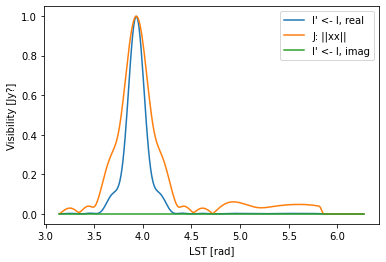

In [41]:
lst_list = [np.pi / 288 * i for i in range(288, 576)]

dec = np.radians(-30.72)

# constants for the LST plot
print("Right ascension:", ra)
print("LST interval", 1 / 288)
print("Declination:", dec)
print("Reference point:", np.radians(-30.72))

list_A = []
list_J = []

for lst in lst_list:
    J = sf.stokes.create_J(ra=ra, dec=dec, lst=lst, radians=True)
    list_J.append(J)
    A = sf.stokes.create_A(J=J)
    list_A.append(A)

list_A = np.array(list_A)
list_J = np.array(list_J)
    
print(list_A[0][0][0])

plt.plot(lst_list, np.real(list_A[:, 0, 0, 0]), label="I' <- I, real")
plt.plot(lst_list, np.abs(list_J[:, 0, 0, 0]), label="J: ||xx||")
plt.plot(lst_list, np.imag(list_A[:, 0, 0, 0]), label="I' <- I, imag")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

In [42]:
print("The following is the universal baseline")
print(sf.ant.baseline(88, 121))

The following is the universal baseline
[-43.92014994  25.13624112  -0.34038648]


In [43]:
len(sf.catalog.obj_catalog)

3872